In [1]:
from diffusers import UNet2DClassConditionModel, DDPMScheduler
import torch
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
unet = UNet2DClassConditionModel(
    64,
    in_channels=3,
    out_channels=3,
    cross_attention_dim=512,
    attention_head_dim=(8, 16, 32, 64),
    num_class_embeds=3,
    down_block_types=(
        "DownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
    ),
    up_block_types=(
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "UpBlock2D",
    ),
    block_out_channels=(64, 128, 256, 512),
    transformer_layers_per_block=(1, 1, 1, 1),
)
unet.load_state_dict(torch.load("results/bean_64_dim64_2/unet.pt"))
unet = unet.to(device="cuda").eval()

In [9]:
from diffusers.utils import check_min_version, randn_tensor

class_label = torch.tensor(
    [0, 1, 2],
    device="cuda",
    dtype=torch.long,
)
image = randn_tensor(
    (3, 3, 64, 64),
    device="cuda",
    dtype=torch.float32,
)

noise_scheduler = DDPMScheduler()

noise_scheduler.set_timesteps(1000)
with torch.no_grad():
    for t in tqdm(noise_scheduler.timesteps):
        model_output = unet(
            image,
            timestep=t.unsqueeze(0).to(image.device),
            class_labels=class_label,
        ).sample
        image = noise_scheduler.step(
            model_output,
            t,
            image,
        ).prev_sample
    #     image = 1 / vae.config.scaling_factor * image
    #     image = image.to(dtype=latents.dtype)
    #     image = vae.decode(image).sample
image = image / 2 + 0.5

100%|██████████| 1000/1000 [00:09<00:00, 102.96it/s]


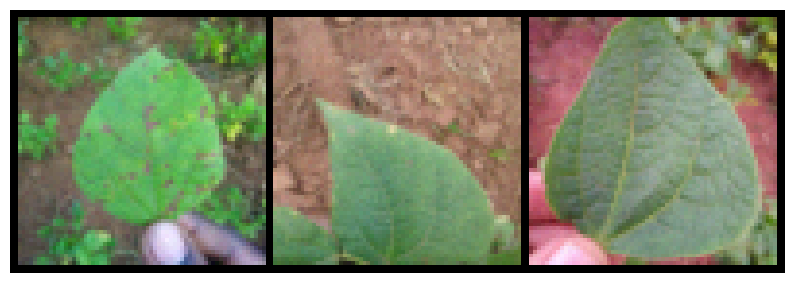

In [10]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
plt.imshow(
    make_grid(image.cpu(), nrow=3).permute(1, 2, 0).numpy(),
)
plt.axis("off")
plt.show()

In [21]:
from diffusers import UNet2DModel, DDIMScheduler, DDPMScheduler, PNDMScheduler
from diffusers.utils import randn_tensor
import torchvision
from PIL import Image
from io import BytesIO
import glob
import random

sr_unet = UNet2DModel.from_pretrained(
    "results/bean_sr_256_0923/checkpoint-19000/unet_ema"
)
sr_unet.load_state_dict(torch.load("results/bean_sr_256_0923/unet.pt"))
sr_unet = sr_unet.to(device="cuda").eval()

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 19000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [93]:
# noise_scheduler = DDIMScheduler(2000,rescale_betas_zero_snr=True, timestep_spacing="trailing")
noise_scheduler = DDPMScheduler(2000, 0.00085, 0.012, "scaled_linear")
# noise_scheduler = PNDMScheduler(2000)

In [17]:
class ImageAugment:
    def __init__(self, shrink_size=2, noise_level=1, down_sample_method=None):
        # noise_level (int): 0: no noise; 1: 75-95% quality; 2:50-75%
        if noise_level == 0:
            self.noise_level = [0, 0]
        elif noise_level == 1:
            self.noise_level = [5, 25]
        elif noise_level == 2:
            self.noise_level = [25, 50]
        else:
            raise KeyError("Noise level should be either 0, 1, 2")
        self.shrink_size = shrink_size
        self.down_sample_method = down_sample_method

    def shrink_img(self, hr_img):
        if self.down_sample_method is None:
            resample_method = random.choice(
                [Image.BILINEAR, Image.BICUBIC, Image.LANCZOS]
            )
        else:
            resample_method = self.down_sample_method
        img_w, img_h = tuple(map(lambda x: int(x / self.shrink_size), hr_img.size))
        lr_img = hr_img.resize((img_w, img_h), resample_method)
        return lr_img

    def add_jpeg_noise(self, hr_img):
        quality = 100 - round(random.uniform(*self.noise_level))
        lr_img = BytesIO()
        hr_img.save(lr_img, format="JPEG", quality=quality)
        lr_img.seek(0)
        lr_img = Image.open(lr_img)
        return lr_img

    def process(self, hr_patch_pil):
        w, h = hr_patch_pil.size
        lr_patch_pil = self.shrink_img(hr_patch_pil)
        if self.noise_level[1] > 0:
            lr_patch_pil = self.add_jpeg_noise(lr_patch_pil)
        lr_patch_pil = lr_patch_pil.resize((w, h), Image.BICUBIC)
        return lr_patch_pil, hr_patch_pil

    def up_sample(self, img, resample):
        width, height = img.size
        return img.resize(
            (self.shrink_size * width, self.shrink_size * height), resample=resample
        )


image_augment = ImageAugment(shrink_size=4, noise_level=1)

In [95]:
# output_type = "tensor"
# guidance_scale = 1.0
noisy_latents = randn_tensor(
    (3, 3, 256, 256),
    device="cuda",
    dtype=torch.float32,
)

image_files = glob.glob("data/valid/*.jpg")
image = [Image.open(f).convert("RGB").resize((256, 256)) for f in image_files]
image = [image_augment.process(img)[0] for img in image]
image_hr = [image_augment.process(img)[1] for img in image]
# image[0]

image = torch.stack([torchvision.transforms.ToTensor()(img) for img in image])
image = image.to(device="cuda", dtype=torch.float32)
image.shape

torch.Size([3, 3, 256, 256])

In [96]:
num_inference_steps = 200
noise_scheduler.set_timesteps(num_inference_steps)
with torch.no_grad():
    for t in tqdm(noise_scheduler.timesteps):
        model_output = sr_unet(
            torch.cat([noisy_latents, image], dim=1),
            timestep=t.unsqueeze(0).to(image.device),
        ).sample
        noisy_latents = noise_scheduler.step(
            model_output,
            t,
            noisy_latents,
        ).prev_sample
image = image * 0.5 + 0.5
image = image.clamp(0, 1).cpu()

100%|██████████| 2000/2000 [01:15<00:00, 26.47it/s]


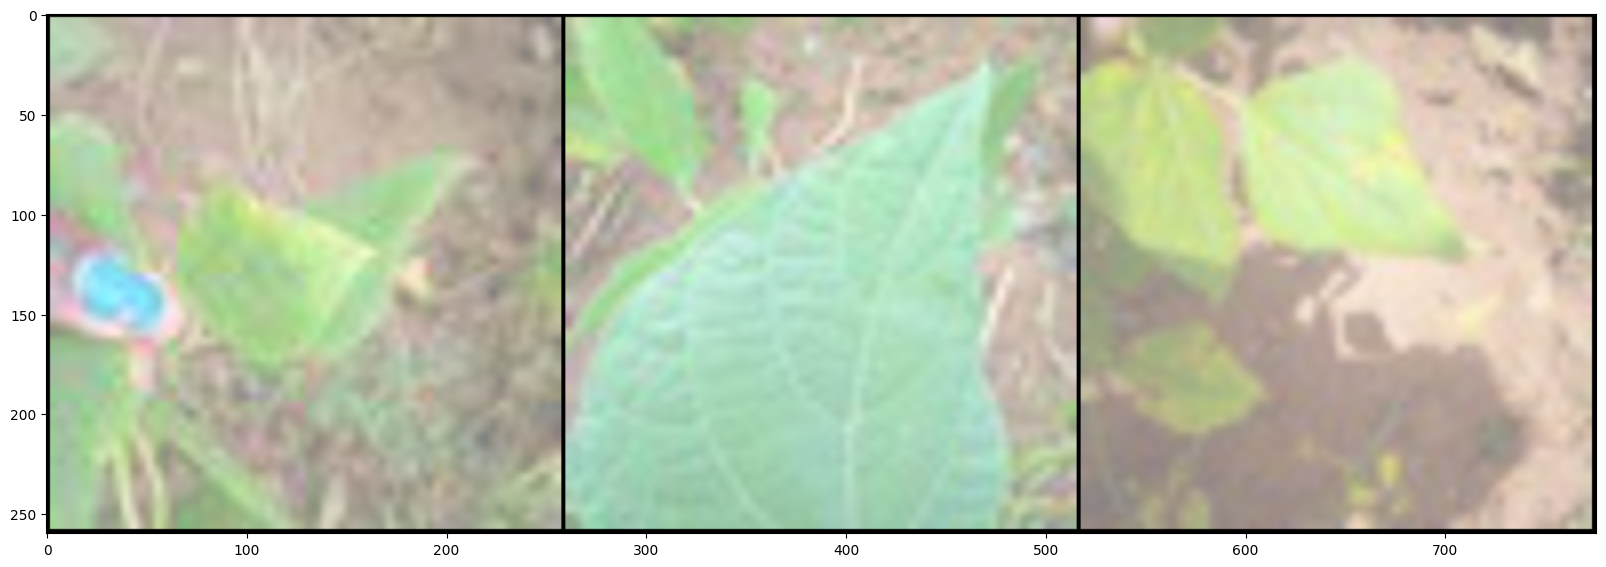

In [97]:
from torchvision.utils import make_grid
from matplotlib import pyplot as plt


plt.figure(figsize=(20, 20))
plt.imshow(make_grid(image, nrow=3).permute(1, 2, 0))

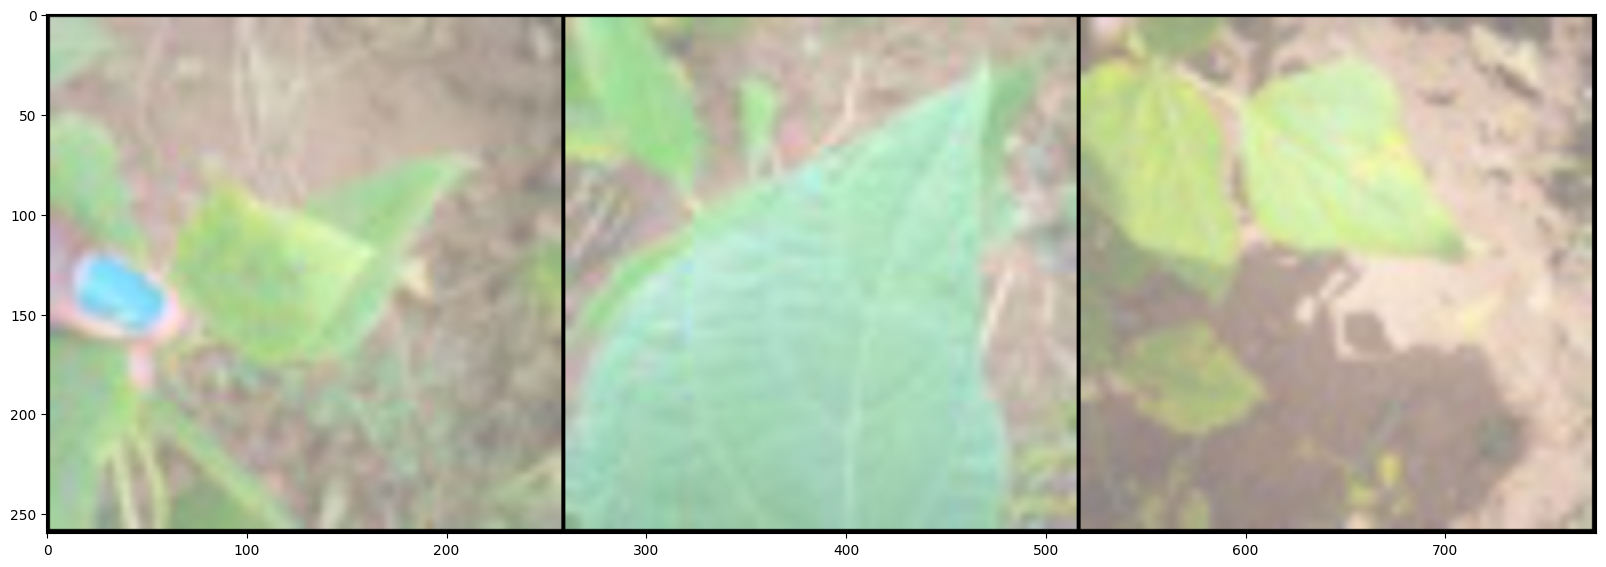

In [86]:
plt.figure(figsize=(20, 20))
plt.imshow(make_grid(image, nrow=4).permute(1, 2, 0))

In [3]:
# classifier-free inference
from diffusers.utils import randn_tensor
from diffusers import DDPMScheduler, UNet2DClassConditionModel

unet = UNet2DClassConditionModel.from_pretrained(
    "results/bean_64_dim64_2/checkpoint-3000/unet_ema"
)
unet.load_state_dict(torch.load("results/bean_64_dim64_2/unet.pt"))
unet = unet.to(device="cuda")


class_labels = torch.tensor(
    [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2],
    device="cuda",
    dtype=torch.long,
)
class_null = torch.tensor([3] * 12, device="cuda", dtype=torch.long).reshape(-1)
image = randn_tensor(
    (12, 3, 64, 64),
    device="cuda",
    dtype=torch.float32,
)
class_labels_input = torch.cat([class_labels, class_null], 0)
model_input = torch.cat([image] * 2)

latent_channels = unet.config.in_channels
unet.config.sample_size = 64
noise_scheduler = DDPMScheduler()

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 3000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DClassConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [4]:
from mypipeline_novae import MyPipeline

pipe = MyPipeline(unet=unet, scheduler=noise_scheduler)
# generator = torch.manual_seed(33)

In [5]:
output = pipe(
    class_labels=[0, 0, 0, 1, 1, 1, 2, 2, 2],
    num_inference_steps=1000,
    # generator=generator,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

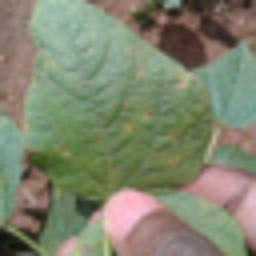

In [6]:
output.images[3].resize((256, 256))

In [7]:
output["images"]

[<PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>]

In [8]:
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
from diffusers.utils import randn_tensor
import torchvision
from PIL import Image
from io import BytesIO
import glob
import random
from torchvision.utils import make_grid

In [9]:
# output_type = "tensor"
# guidance_scale = 1.0
noisy_latents = randn_tensor(
    (9, 3, 256, 256),
    device="cuda",
    dtype=torch.float32,
)

image = [
    torchvision.transforms.ToTensor()(img.resize((256, 256)))
    for img in output["images"]
]
# image[0]

image = torch.stack([img for img in image])
image = image * 2 - 1
image = image.to(device="cuda", dtype=torch.float32)

In [10]:
sr_unet = UNet2DModel.from_pretrained(
    "results/bean_sr_64to256/checkpoint-32000/unet_ema"
)
sr_unet.load_state_dict(torch.load("results/bean_sr_64to256/unet.pt"))
sr_unet = sr_unet.to(device="cuda")

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 32000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [11]:
noise_scheduler = DDIMScheduler(2000, 0.00085, 0.012, "scaled_linear")
num_inference_steps = 200
eta = 0.0
noise_scheduler.set_timesteps(num_inference_steps, device="cuda")
timesteps_tensor = noise_scheduler.timesteps

In [12]:
with torch.no_grad():
    for t in tqdm(noise_scheduler.timesteps):
        model_output = sr_unet(
            torch.cat([noisy_latents, image], dim=1),
            timestep=t.unsqueeze(0).to(image.device),
        ).sample
        noisy_latents = noise_scheduler.step(
            model_output,
            t,
            noisy_latents,
            eta=eta,
        ).prev_sample
    
image_sr = noisy_latents

100%|██████████| 200/200 [00:21<00:00,  9.50it/s]


In [13]:
noisy_latents = noisy_latents * 0.5 + 0.5
noisy_latents = noisy_latents.clamp(0, 1).cpu()

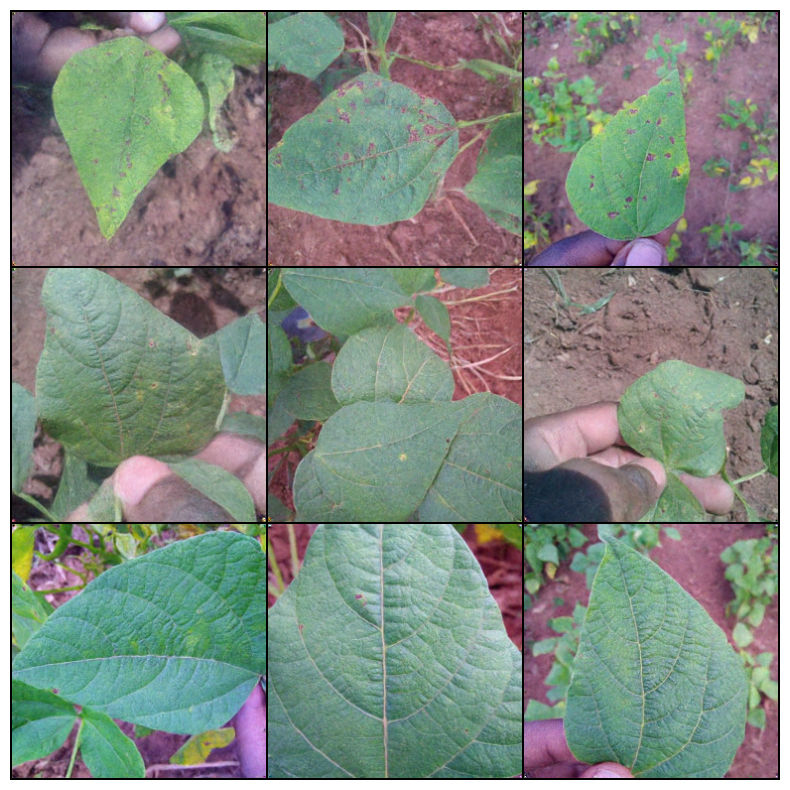

In [14]:
# step=200 eta=0.
plt.figure(figsize=(10, 10))
plt.imshow(
    make_grid(noisy_latents.cpu(), nrow=3).permute(1, 2, 0).numpy(),
)
plt.axis("off")
plt.show()

In [16]:
unet_refine = UNet2DModel.from_pretrained("results/bean_refine/checkpoint-32000/unet_ema")
unet_refine.load_state_dict(torch.load("results/bean_refine/unet.pt"))
unet_refine = unet_refine.to("cuda")


The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 32000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [17]:
noise_scheduler = DDIMScheduler(2000, 0.00085, 0.012, "scaled_linear")
num_inference_steps = 200
eta = 0.0
noise_scheduler.set_timesteps(num_inference_steps, device="cuda")
timesteps_tensor = noise_scheduler.timesteps

In [18]:
# output_type = "tensor"
# guidance_scale = 1.0
noisy_latents = randn_tensor(
    (9, 3, 256, 256),
    device="cuda",
    dtype=torch.float32,
)



image = image_sr.to("cuda")


In [19]:
with torch.no_grad():
    for t in tqdm(noise_scheduler.timesteps):
        model_output = sr_unet(
            torch.cat([noisy_latents, image], dim=1),
            timestep=t.unsqueeze(0).to(image.device),
        ).sample
        noisy_latents = noise_scheduler.step(
            model_output,
            t,
            noisy_latents,
            eta=eta,
        ).prev_sample
    

100%|██████████| 200/200 [00:21<00:00,  9.51it/s]


In [20]:
noisy_latents = noisy_latents * 0.5 + 0.5
noisy_latents = noisy_latents.clamp(0, 1).cpu()

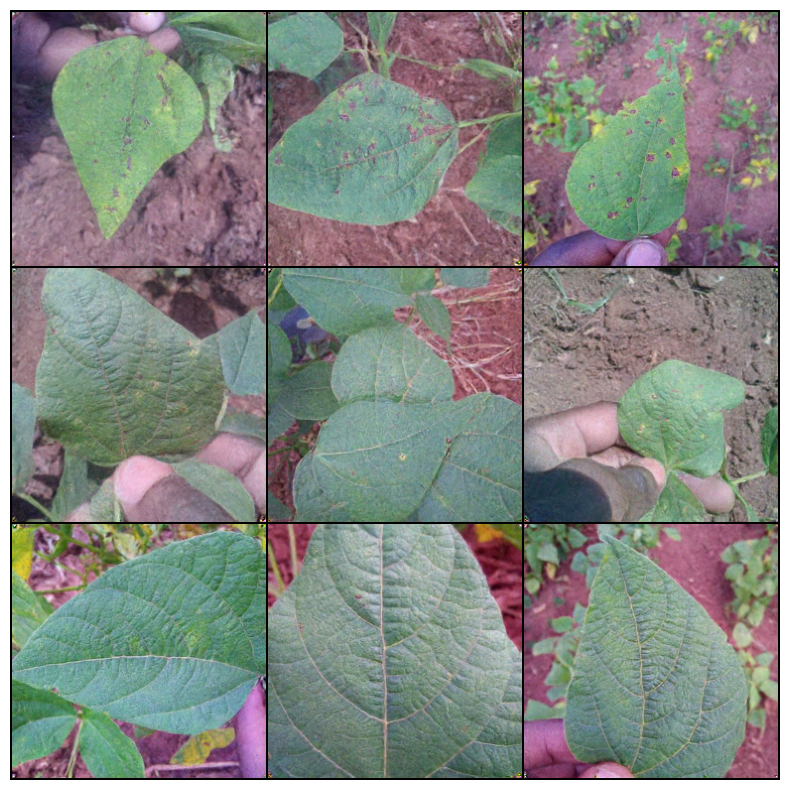

In [21]:
# step=200 eta=0.5
plt.figure(figsize=(10, 10))
plt.imshow(
    make_grid(noisy_latents.cpu(), nrow=3).permute(1, 2, 0).numpy(),
)
plt.axis("off")
plt.show()